## How the sweep data was generated



This notebook visualises pre-computed sweep data rather than generating all realisations live. Those data products were created on a SLURM cluster using the bash scripts in the `bash/` directory, in particular:



- [bash/fires_PA_sweep_191001.sh](bash/fires_PA_sweep_191001.sh)

- [bash/run_191001.sh](bash/run_191001.sh) (and related helper scripts)



### fires_PA_sweep_191001.sh (single-parameter SD sweep)



The script [bash/fires_PA_sweep_191001.sh](bash/fires_PA_sweep_191001.sh) is a SLURM array job that:



1. Reads the Gaussian parameter file `gparams.toml` for FRB 191001 and loads it into a numeric array.

2. Automatically detects which column has a non-zero sweep step in the last row (exactly one column must be varying).

3. Extracts the sweep start, stop and step for that parameter (e.g. `tau_sd`, `N_sd`, etc.).

4. For each SLURM array index (`SLURM_ARRAY_TASK_ID`), sets up a chunk identifier (`sweep_<chunk>`) and output directory of the form:

   - `191001/${PLOT}/${VAR}/start_<START>_stop_<STOP>_step_<STEP>/<OVERRIDE_SUFFIX>`

5. Builds `--override-param` arguments from environment variables (e.g. `N`, `N_sd`, `mg_width_low`, `mg_width_high`) so you can fix or modify other parameters while sweeping one of them.

6. Calls the `fires` CLI once per chunk with, roughly:



   ```bash

   fires \

     -f "sweep_${CHUNK}" \

     -v \

     --mode psn \

     --seed 3 \

     --nseed 500 \

     --write \

     --plot ${PLOT} \

     --config-dir "$CONFDIR" \

     --output-dir "$OUTDIR" \

     --override-plot show_plots=false save_plots=false \

     --ncpu ${SLURM_CPUS_PER_TASK} \

     --sweep-mode sd \

     "${OVERRIDE_ARGS[@]}" \

     --snr 174

   ```



Key points:



- `--sweep-mode sd` tells FIRES to hold the mean of the varied parameter fixed and sweep its micro standard deviation.

- `--nseed 500` generates 500 realisations per sweep point for robust statistics.

- `--write` stores the simulation products (dynamic spectra, time series, etc.) to disk under the chunk-specific output directory.

- `--override-plot show_plots=false save_plots=false` disables figure saving and interactive windows on the cluster so only the data products are written.



The directory used in this notebook as `SIM_DATA_DIR` (for example `/mnt/Storage/FIRES/191001/PA/Nsnr/n500/N/`) is a consolidated location where the outputs of these sweep jobs have been gathered.



### run_191001.sh (orchestrating multiple sweeps)



The script [bash/run_191001.sh](bash/run_191001.sh) demonstrates how multiple sweeps were launched by submitting different SLURM jobs with varying environment variables. For example:



- Different `N` values (number of micro-shots) are submitted as separate jobs (e.g. 5, 10, 20, 100, 1000).

- Commented examples show how to also vary `mg_width_low` and `mg_width_high` or PA scatter, by exporting those variables and reusing a common loop script.



In practice, each sbatch line in [bash/run_191001.sh](bash/run_191001.sh) calls a loop script (such as `fires_loop_191001.sh`) which in turn sets the appropriate environment variables and invokes [bash/fires_PA_sweep_191001.sh](bash/fires_PA_sweep_191001.sh) or a similar sweep driver.



### Relation to this notebook



- The heavy Monte Carlo work (500 realisations per grid point, across many grid points and parameter choices) is done once on the cluster via these SLURM scripts.

- The resulting simulation data are stored in a structured directory tree (e.g. under `191001/PA/...` or `/mnt/Storage/FIRES/191001/...`).

- This notebook picks up that pre-computed grid via `SIM_DATA_DIR` and calls `fires` in analytical mode (`-p l_frac`, `-d SIM_DATA_DIR`) to reconstruct and visualise the `l_frac` curves and observational overlays without having to re-run the full sweep.



If you wish to regenerate the sweep yourself, you can:



- Edit [bash/fires_PA_sweep_191001.sh](bash/fires_PA_sweep_191001.sh) to point to your own `CONFDIR`, `gparams.toml` and output root, then submit it with `sbatch` on a SLURM cluster.

- Or run it as a regular bash script on a local machine (ignoring the `#SBATCH` lines), but be aware that the full sweep is computationally intensive.

# FIRES Tutorial: PA / L-fraction Sweep for FRB 20191001A

 

This notebook reproduces the PA / linear-fraction sweep used for the phase-lead analysis of FRB 20191001A.

 

It is based on the shell script:

 

- paper/191001/PA_sweep/L0.95/l_n.sh

(more data is available under the L0.6 folder, where L/I=0.6)
 

The goal is to show how to call the `fires` CLI from a notebook to generate the `l_frac` (linear polarisation fraction) analytical plot, including an overlay of observational data.

## 1. Prerequisites



To run this notebook you need:



- FIRES installed in your current Python environment (`pip install -e .` from the repo root).

- The `fires` command available on your PATH.

- Access to the simulation and observational data used in the original script:

  - Simulation data directory: `/mnt/Storage/FIRES/191001/PA/Nsnr/n500/N/`

  - Observational data directory: `/mnt/Storage/craft_frb/191001`

  - Observational parameter file: `/mnt/Storage/craft_frb/191001/parameters.txt`

  - Plot configuration file: `paper/191001/PA_sweep/L0.95/plotparams.toml`



If your paths differ, update the variables in the next cell accordingly.

In [ ]:
from pathlib import Path



# ---------------------------------------------------------------------------

# Paths and identifiers

# ---------------------------------------------------------------------------

# Adjust these if your directory layout is different.



REPO_ROOT = Path('~/Documents/GitHub/FIRES').expanduser()



# Directory that contains the PA sweep config + plotparams.toml

PA_SWEEP_DIR = REPO_ROOT / 'paper' / '191001' / 'PA_sweep' / 'L0.95'



# Simulation data directory (from original l_n.sh)

SIM_DATA_DIR = Path('/mnt/Storage/FIRES/191001/PA/Nsnr/n500/N/')



# Observational data + parameters (from original l_n.sh)
# IQUV npy files found at https://researchdata.edu.au/craft-high-time-release-1/3573930
# The directory should contain individual npy files for I, Q, U, V, where each is a 2D array named something like *_I.npy, etc.,
# and .npy files containing frqeuency and time axes, *_freq.npy and *_time.npy.
# Can omit observational overlay if needed.

OBS_DATA_DIR = Path('/mnt/Storage/craft_frb/191001')

OBS_PARAMS_FILE = OBS_DATA_DIR / 'parameters.txt'



# Output directory (here we mirror the original script: current PA_SWEEP_DIR)

OUTPUT_DIR = PA_SWEEP_DIR



# FRB identifier and plot mode

FRB_ID = 'phase_paper_lead_N_L0.95'

PLOT_MODE = 'l_frac'



REPO_ROOT, PA_SWEEP_DIR, SIM_DATA_DIR, OBS_DATA_DIR, OUTPUT_DIR

(PosixPath('/home/joel/Documents/GitHub/FIRES'),
 PosixPath('/home/joel/Documents/GitHub/FIRES/paper/191001/PA_sweep/L0.95'),
 PosixPath('/mnt/Storage/FIRES/191001/PA/Nsnr/n500/N'),
 PosixPath('/mnt/Storage/craft_frb/191001'),
 PosixPath('/home/joel/Documents/GitHub/FIRES/paper/191001/PA_sweep/L0.95'))

## 2. Inspect FIRES CLI and configuration



Before running the sweep, it can be useful to:



- Confirm that the `fires` command is available.

- Optionally preview the relevant TOML configuration files that control the PA sweep and plotting.



The next cell checks that `fires` is on your PATH. If this fails, make sure you have activated the environment where FIRES was installed.

In [3]:
# Show top of `fires --help` to confirm installation

!fires --help | head -n 30



# Optionally, uncomment these lines to inspect the sweep / plot configs

# !sed -n '1,80p' {PA_SWEEP_DIR / 'plotparams.toml'}

# !sed -n '1,80p' {REPO_ROOT / 'paper' / '191001' / 'gparams.toml'}

usage: fires [-h] [--config-dir CONFIG_DIR] [--init-config]
             [--edit-config {gparams,simparams,scparams,plotparams}] [-f] [-d]
             [-o] [--write] [-v] [-m] [--seed] [--nseed] [--ncpu] [--sefd]
             [--snr] [--scint] [--chi2-fit]
             [--override-param PARAM=VALUE [PARAM=VALUE ...]] [-b]
             [--phase-window] [--freq-window] [--buffer] [-p  [...]]
             [--plot-config] [--override-plot PARAM=VALUE [PARAM=VALUE ...]]
             [--logstep LOGSTEP] [--sweep-mode]
             [--compare-windows FREQ:PHASE [FREQ:PHASE ...]] [--obs-data]
             [--obs-params]

FIRES: The Fast, Intense Radio Emission Simulator. Simulate Fast Radio Bursts (FRBs) with scattering and polarisation effects

options:
  -h, --help            show this help message and exit
  --config-dir CONFIG_DIR
                        Override user config dir (default: ~/.config/fires)
  --init-config         Create user config from packaged defaults
  --edit-config {g

## 3. Run the PA / L-fraction sweep (l_n.sh equivalent)



The original shell script `l_n.sh` runs:



```bash

fires -f phase_paper_lead_N_L0.95 -p l_frac \

      -d /mnt/Storage/FIRES/191001/PA/Nsnr/n500/N/ \

      -o . -v \

      --obs-data /mnt/Storage/craft_frb/191001 \

      --obs-params /mnt/Storage/craft_frb/191001/parameters.txt \

      --plot-config ./plotparams.toml \

      --phase-window first

```



This:



- Uses precomputed simulation realisations (`-d ...Nsnr/n500/N/`).

- Produces the analytical `l_frac` plot (`-p l_frac`) as a function of the swept parameter.

- Overlays observational data from `/mnt/Storage/craft_frb/191001`.

- Uses a custom plotting configuration `plotparams.toml` in the PA sweep directory.

- Restricts the analysis to the **first** phase window of the burst (`--phase-window first`), i.e., the leading edge.



The next cell reproduces this call, but uses the path variables defined above so it is easier to adapt.

[DEBUG] FIRES: Verbose logging enabled.
DEBUG:FIRES:Verbose logging enabled.
INFO:root:Output directory: '/home/joel/Documents/GitHub/FIRES/paper/191001/PA_sweep/L0.95' 

INFO:root:Loading grouped data from /mnt/Storage/FIRES/191001/PA/Nsnr/n500/N
INFO:root:Found 100 .pkl files
INFO:root:Grouped into 5 series (loader-side sorted).
INFO:root:  N=5: 20 files
INFO:root:  N=10: 20 files
INFO:root:  N=20: 20 files
INFO:root:  N=100: 20 files
INFO:root:  N=1000: 20 files
INFO:root:Processing N=5:
INFO:root:Median S/N at:
 lowest x: S/N = 174.61870195917797, 
highest x: S/N = 174.61870195917797

INFO:root:Processing N=10:
INFO:root:Median S/N at:
 lowest x: S/N = 174.20220000652714, 
highest x: S/N = 174.20220000652714

INFO:root:Processing N=20:
INFO:root:Median S/N at:
 lowest x: S/N = 174.9315358105332, 
highest x: S/N = 174.9315358105332

INFO:root:Processing N=100:
INFO:root:Median S/N at:
 lowest x: S/N = 174.21468452589352, 
highest x: S/N = 174.21468452589352

INFO:root:Processing N=1

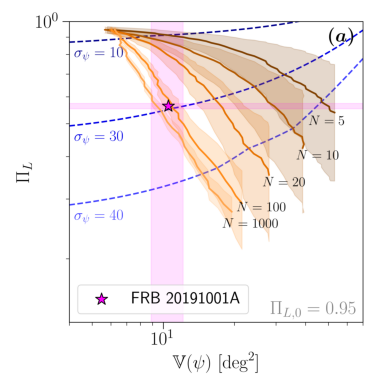

In [15]:
# ---------------------------------------------------------------------------

# l_n.sh equivalent: run FIRES l_frac analytic sweep with observational overlay

# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

!fires -f {FRB_ID} -p {PLOT_MODE} \
  -d {SIM_DATA_DIR} \
  -o {OUTPUT_DIR} -v \
  --obs-data {OBS_DATA_DIR} \
  --obs-params {OBS_PARAMS_FILE} \
  --plot-config {PA_SWEEP_DIR / 'plotparams.toml'} \
  --phase-window first \
  --override-plot "extension=png"

img = mpimg.imread(f"{OUTPUT_DIR}/phase_paper_lead_N_L0.95_log_freq_full-band_phase_leading_l_frac.png")
plt.axis('off')
plt.imshow(img)